# TP 01 {-}

#  3. (40 puntos) Redes convolucionales para detección de glaucoma en imágenes de fondo de ojo. {-}

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch import nn, optim
from matplotlib import cm
from matplotlib import style
from matplotlib.pyplot import imshow
#%matplotlib widget
%matplotlib inline
style.use('default')

## 3.1. (20 puntos) Implemente el filtro de «Unsharp masking» para la mejora de las imágenes, según lo especificado en el material del curso. {-}
   
Una explicación más amplia puede ser encontrada en el documento TP-01.pdf

torch.Size([3, 227, 227])


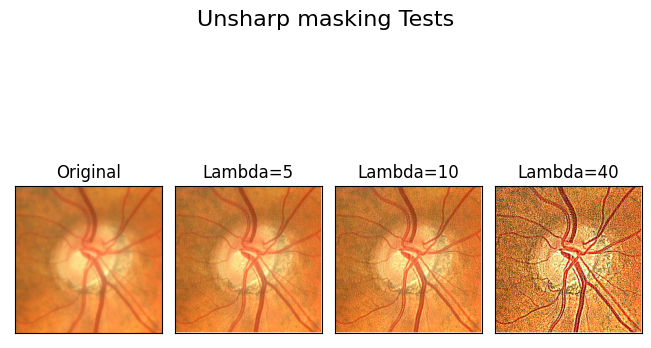

In [2]:
#Gaussian blur filter
def gaussian_blur():
    #Gaussian blur filter
    F = torch.tensor([[0.0625,0.125,0.0625],[0.125,0.25,0.125],[0.0625,0.125,0.0625]]).float()
    return F

# Determine the new image size after the filter is applied.
def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0
    
    # From 0 up to img size (if img size = 224, then up to 223)
    for i in range(img_size):
        # Add the kernel size (let's say 3) to the current i
        added = i + kernel_size
        # It must be lower than the image size
        if added <= img_size:
            # Increment if so
            num_pixels += 1
            
    return num_pixels

#Manual convlution method for 3 channel images.
def convolution(U,F):

    new_size = calculate_target_size(img_size=U.shape[1],kernel_size=U.shape[0])

    kernel=F

    kernel_shape = kernel.shape[0]

    conv_img = torch.zeros(3,new_size,new_size)
    
    for g in range(3):
        for i in range(new_size):
            for j in range(new_size):
                mat = U[g,i:i+kernel_shape,j:j+kernel_shape]
                conv_img[g, i, j] = torch.sum(torch.multiply(mat,kernel))

    #Add padding to the convuluted image so the size is the same for original and convoluted image.
    conv_img=torchvision.transforms.Pad(1)(conv_img)
    
    return conv_img

def unsharp_masking(U,amount):
    return U + (U-convolution(U,gaussian_blur())) * amount

#Test with one of the images of the dataset.
U = read_image(r'.\dataset_train_test\dataset_train_test\train\0\Im107_ACRIMA.jpg') / 255
U=torchvision.transforms.Resize(227)(U)
print(U.shape)

#To normalize the values for each pixel.
def disp(x): return (x.clamp(0,1) * 255).byte().permute(1,2,0).cpu()

#Plot the images with the unsharp masking filter applied.
fig, (ax, bx, cx, dx) = plt.subplots(1,4,constrained_layout=True)
fig.suptitle('Unsharp masking Tests', fontsize=16)
ax.set_title("Original")
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(disp(U))

bx.set_title("Lambda=5")
bx.set_yticklabels([])
bx.set_xticklabels([])
bx.set_xticks([])
bx.set_yticks([])
bx.imshow(disp(unsharp_masking(U,5)))

cx.set_title("Lambda=10")
cx.set_yticklabels([])
cx.set_xticklabels([])
cx.set_xticks([])
cx.set_yticks([])
cx.imshow(disp(unsharp_masking(U,10)))

dx.set_title("Lambda=40")
dx.set_yticklabels([])
dx.set_xticklabels([])
dx.set_xticks([])
dx.set_yticks([])
dx.imshow(disp(unsharp_masking(U,40)))

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


## Inicio de sección para definir el modelo AlexNet. {-}

## Resize images {-}

In [3]:
#AlexNet model uses images 227x227.
img_size = 227

#No normalization as document says.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((img_size, img_size))])

In [4]:
#Code just to ease the load from local folder
import os
print(os.listdir("."))

from os import walk
for (dirpath, dirnames, filenames) in walk("."):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)
#     print("File name: ", filenames)

['#TP_1_Optimizacion_Redes_Neuronales.lyx#', 'dataset_train_test', 'dataset_train_test.zip', 'PAPILA_dataset.pdf', 'Punto 3.lyx', 'Readme.txt', 'Results.md', 'Results.txt', 'Results_Selected_LR.md', 'Results_v2.md', 'Tests.docx', 'TP1 - Newton-Rhapson.ipynb', 'TP1 - Optimizacion de Funciones.ipynb', 'TP1 - Perceptron multi-capa - propEntregable-Juan-PC.ipynb', 'TP1 - Perceptron multi-capa - propEntregable.ipynb', 'TP1 - Perceptron multi-capa - propEntregablev2.pdf', 'TP1 - Perceptron multi-capa.ipynb', 'TP1 - UnsharpMask-AlexNet.ipynb', 'TP1 - UnsharpMask-AlexNet.pdf', 'TP_01.pdf', 'TP_1_Optimizacion_Redes_Neuronales.lyx', 'TP_1_Optimizacion_Redes_Neuronales.lyx~', 'TP_1_Optimizacion_Redes_Neuronales.pdf']
Directory path:  .
Folder name:  ['dataset_train_test']
Directory path:  .\dataset_train_test
Folder name:  ['dataset_train_test']
Directory path:  .\dataset_train_test\dataset_train_test
Folder name:  ['test', 'train']
Directory path:  .\dataset_train_test\dataset_train_test\test
Fo

## Load the dataset {-}

torch.Size([32, 3, 227, 227])


C:\Users\jcord\AppData\Local\Temp\ipykernel_41920\629819469.py:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2985.)
  axs[0,0].imshow(images[0].T.numpy().squeeze(), cmap='gray_r')


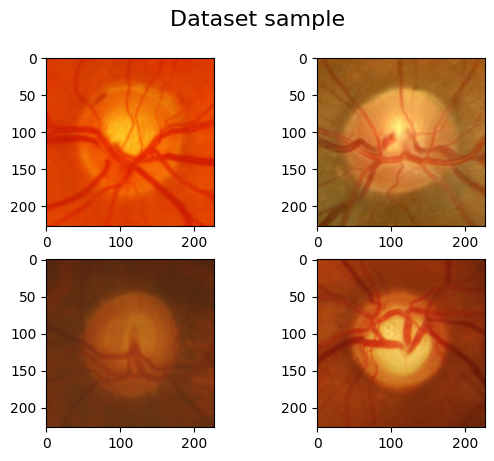

In [5]:
def load_test_train_data_tp1():
    trainset = torchvision.datasets.ImageFolder(r'.\dataset_train_test\dataset_train_test\train',transform = transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

    testset = torchvision.datasets.ImageFolder(r'.\dataset_train_test\dataset_train_test\test',transform = transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)
    return trainloader, testloader

trainloader, testloader = load_test_train_data_tp1()
dataiter = iter(trainloader) # creating a iterator
images, labels = dataiter.next() # creating images for image and lables for image number (0 to 9) 

print(images.mT.shape)

fig, axs = plt.subplots(2,2)
fig.suptitle("Dataset sample", fontsize=16)
axs[0,0].imshow(images[0].T.numpy().squeeze(), cmap='gray_r')
axs[0,1].imshow(images[1].T.numpy().squeeze(), cmap='gray_r')
axs[1,0].imshow(images[2].T.numpy().squeeze(), cmap='gray_r')
axs[1,1].imshow(images[3].T.numpy().squeeze(), cmap='gray_r')


## 3.2. (20 puntos) Implemente manualmente (especificando las capas) en pytorch la arquitectura de AlexNet. Entrene la red usando el conjunto de datos de imágenes de fondo de ojo. Calibre los hiper-parámetros necesarios para obtener los mejores resultados posibles y reportelos. Ejecute el entrenamiento 10 veces por 15 épocas por corrida, y reporte la tasa de aciertos, falsos positivos y falsos negativos promedio y su desviación estándar para esas 10 corridas. {-}   

In [6]:
#AlexNet model definition, we use as reference the published paper "ImageNet Classification with Deep Convolutional Neural Networks" and the provided documentation from previous classes.
def create_AlexNet_model():
    class AlexNet(nn.Module):
        def __init__(self):
            super(AlexNet, self).__init__()

            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
                nn.BatchNorm2d(96),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer4 = nn.Sequential(
                nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer5 = nn.Sequential(
                nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(9216, 4096),
                nn.ReLU())
            self.fc1 = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU())
            self.fc2= nn.Sequential(
                nn.Linear(4096, 2),nn.LogSoftmax(dim=1))
                #nn.Linear(4096, 2),nn.Softmax(dim=1))

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = self.layer5(out)
            out = out.reshape(out.size(0), -1)
            out = self.fc(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out
 
    cnn = AlexNet()
    return cnn

    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = create_AlexNet_model()
cnn_model.to(device)
#Error function
criterion = nn.NLLLoss() 

print("AlexNet model: ")
print(cnn_model)

AlexNet model: 
AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [7]:
#This code trains the model previously constructed with the loaded dataset from previous steps.
def train_model(model, criterion, epochs = 15, lr = 0.01, is_MLP = False):

    time0 = time()    
    running_loss_list= []
    epochs_list = []
    optimizer = optim.SGD(model.parameters(), lr= lr, momentum=0.9)
    for e in range(epochs):
        running_loss = 0
        
        #go for every batch
        for images, labels in trainloader:
            #move data to specific device
            images = images.to(device)
            labels = labels.to(device)
            # Flatenning MNIST images with size [64,784] (for MLP)
            if(is_MLP):
              images = images.view(images.shape[0], -1) 
            
            # defining gradient in each epoch as 0
            optimizer.zero_grad()            
            # modeling for each image batch
            output = model(images)

            # calculating the loss
            loss = criterion(output, labels)

            # This is where the model learns by backpropagating
            loss.backward()

            # And optimizes its weights here
            optimizer.step()

            # calculating the loss
            running_loss += loss.item()

        else:
            print("- Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    return model

print("### Training AlexNet model")
cnn_model = train_model(cnn_model, criterion, epochs = 15, lr = 0.01, is_MLP = False)

### Training AlexNet model
- Epoch 0 - Training loss: 0.5225886087864637
- Epoch 1 - Training loss: 0.3469889238476753
- Epoch 2 - Training loss: 0.28907499369233847
- Epoch 3 - Training loss: 0.2131674624979496
- Epoch 4 - Training loss: 0.19003896368667483
- Epoch 5 - Training loss: 0.20702171605080366
- Epoch 6 - Training loss: 0.15682306489907205
- Epoch 7 - Training loss: 0.1703691139118746
- Epoch 8 - Training loss: 0.13560482603497803
- Epoch 9 - Training loss: 0.13303680554963648
- Epoch 10 - Training loss: 0.14810354763176292
- Epoch 11 - Training loss: 0.09577572834677994
- Epoch 12 - Training loss: 0.12820055824704468
- Epoch 13 - Training loss: 0.11982646654359996
- Epoch 14 - Training loss: 0.08340773831878323

Training Time (in minutes) = 0.6707083900769552


In [8]:
#Test the model.
def test_model_cnn(testloader, model):
  correct_count, all_count, false_positive = 0, 0, 0
  for images,labels in testloader:
    #move data to specific device
    images = images.to(device)
    labels = labels.to(device)
    #get model output
    with torch.no_grad():
      outputs = model(images)
    for i in range(len(labels)):
      #apply exp as the activation function has the log
      output_observation = torch.exp(outputs[i, :])
      #get predicted label
      output_observation_np = list(output_observation.cpu().numpy())
      pred_label = output_observation_np.index(max(output_observation_np))
      #get the label
      true_label = labels.cpu().numpy()[i]
      if(true_label == pred_label):
        correct_count += 1
      else:
        if(true_label==0):
            false_positive += 1
      all_count += 1   

  print("")
  print("- Number Of Images Tested =", all_count)
  print("- Number Of Correct Tests =", correct_count)
  print("- Number Of Incorrect Tests =", all_count - correct_count)
  print("- Number Of False Positive Tests =", false_positive)
  print("- Number Of False Negative Tests =", (all_count - correct_count) - false_positive)
  print("\nModel Accuracy (Average) =", np.round((correct_count/all_count)*100,4),"%")

print("### Testing AlexNet model")
test_model_cnn(testloader, cnn_model)

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 197
- Number Of Incorrect Tests = 13
- Number Of False Positive Tests = 10
- Number Of False Negative Tests = 3

Model Accuracy (Average) = 93.8095 %


In [9]:
#Calculate the Standard deviation for the different runs with learning rates.
results=[178,169,204,196,192,187,197,200,199,201]
results2=[201,200,200,199,199,189,194,202,197,202]

print("Stadard deviation:",np.std(results))
print("Stadard deviation:",np.std(results2))

Stadard deviation: 10.621205204683694
Stadard deviation: 3.848376280978771


# Iterations to find the best LR for the model.

## Iteration 1

### Training AlexNet model

- Epoch 0 - Training loss: 3.466971807181835
- Epoch 1 - Training loss: 0.9399996288120747
- Epoch 2 - Training loss: 0.952039822936058
- Epoch 3 - Training loss: 0.6585316099226475
- Epoch 4 - Training loss: 0.4611892681568861
- Epoch 5 - Training loss: 0.4217939144000411
- Epoch 6 - Training loss: 0.42551492247730494
- Epoch 7 - Training loss: 0.3356456020846963
- Epoch 8 - Training loss: 0.33745836978778243
- Epoch 9 - Training loss: 0.31369887571781874
- Epoch 10 - Training loss: 0.276780785061419
- Epoch 11 - Training loss: 0.293039171025157
- Epoch 12 - Training loss: 0.27116969507187605
- Epoch 13 - Training loss: 0.2118628853932023
- Epoch 14 - Training loss: 0.21507969964295626

Training Time (in minutes) = 0.6591819167137146

### Testing AlexNet model


- Number Of Images Tested = 210
- Number Of Correct Tests = 178
- Number Of Incorrect Tests = 32
- Number Of False Positive Tests = 29
- Number Of False Negative Tests = 3

Model Accuracy (Average) = 84.7619 %

## Iteration 2

### Training AlexNet model
- Epoch 0 - Training loss: 3.2027845717966557
- Epoch 1 - Training loss: 0.9780878517776728
- Epoch 2 - Training loss: 1.1219577118754387
- Epoch 3 - Training loss: 0.795509222894907
- Epoch 4 - Training loss: 0.6494000591337681
- Epoch 5 - Training loss: 0.4571275878697634
- Epoch 6 - Training loss: 0.5303807053714991
- Epoch 7 - Training loss: 0.5396288810297847
- Epoch 8 - Training loss: 0.386084558442235
- Epoch 9 - Training loss: 0.30447541922330856
- Epoch 10 - Training loss: 0.4157729558646679
- Epoch 11 - Training loss: 0.45481853000819683
- Epoch 12 - Training loss: 0.4249056512489915
- Epoch 13 - Training loss: 0.6059059808030725
- Epoch 14 - Training loss: 0.6093654371798038

Training Time (in minutes) = 0.607205065091451

### Testing AlexNet model


- Number Of Images Tested = 210
- Number Of Correct Tests = 169
- Number Of Incorrect Tests = 41
- Number Of False Positive Tests = 11
- Number Of False Negative Tests = 30

Model Accuracy (Average) = 80.4762 %

# LR 0.01

## Iteration 1

### Training AlexNet model
- Epoch 0 - Training loss: 0.5268608136102557
- Epoch 1 - Training loss: 0.36485178279690444
- Epoch 2 - Training loss: 0.32854316430166364
- Epoch 3 - Training loss: 0.2671946748159826
- Epoch 4 - Training loss: 0.28669610945507884
- Epoch 5 - Training loss: 0.21644524508155882
- Epoch 6 - Training loss: 0.16123293130658567
- Epoch 7 - Training loss: 0.14714646944776177
- Epoch 8 - Training loss: 0.12932269531302154
- Epoch 9 - Training loss: 0.09250835710554384
- Epoch 10 - Training loss: 0.06334813521243632
- Epoch 11 - Training loss: 0.11503208964131773
- Epoch 12 - Training loss: 0.08692139474442229
- Epoch 13 - Training loss: 0.07841975153132807
- Epoch 14 - Training loss: 0.054170610499568284

Training Time (in minutes) = 0.6602014263470968

### Testing AlexNet model


- Number Of Images Tested = 210
- Number Of Correct Tests = 204
- Number Of Incorrect Tests = 6
- Number Of False Positive Tests = 5
- Number Of False Negative Tests = 1

Model Accuracy (Average) = 97.1429 %

## Iteration 2

### Training AlexNet model
- Epoch 0 - Training loss: 0.6366985570639372
- Epoch 1 - Training loss: 0.3185109249316156
- Epoch 2 - Training loss: 0.28442566376179457
- Epoch 3 - Training loss: 0.26357863703742623
- Epoch 4 - Training loss: 0.2341797649860382
- Epoch 5 - Training loss: 0.16988179099280387
- Epoch 6 - Training loss: 0.21602441067807376
- Epoch 7 - Training loss: 0.17573917703703046
- Epoch 8 - Training loss: 0.14310844847932458
- Epoch 9 - Training loss: 0.1454107970930636
- Epoch 10 - Training loss: 0.2047864175401628
- Epoch 11 - Training loss: 0.14335097861476243
- Epoch 12 - Training loss: 0.09782545431517065
- Epoch 13 - Training loss: 0.06703998637385666
- Epoch 14 - Training loss: 0.11145321454387158

Training Time (in minutes) = 0.6667162219683329

### Testing AlexNet model


- Number Of Images Tested = 210
- Number Of Correct Tests = 196
- Number Of Incorrect Tests = 14
- Number Of False Positive Tests = 13
- Number Of False Negative Tests = 1

Model Accuracy (Average) = 93.3333 %

# LR 0.03

## Iteration 1

### Training AlexNet model
- Epoch 0 - Training loss: 1.0302603468298912
- Epoch 1 - Training loss: 0.45345357339829206
- Epoch 2 - Training loss: 0.3365689655765891
- Epoch 3 - Training loss: 0.26739984890446067
- Epoch 4 - Training loss: 0.3605161104351282
- Epoch 5 - Training loss: 0.47764685400761664
- Epoch 6 - Training loss: 0.4796533677726984
- Epoch 7 - Training loss: 0.4083690168336034
- Epoch 8 - Training loss: 0.33933584252372384
- Epoch 9 - Training loss: 0.2630862295627594
- Epoch 10 - Training loss: 0.21916685719043016
- Epoch 11 - Training loss: 0.21095802541822195
- Epoch 12 - Training loss: 0.20188841805793345
- Epoch 13 - Training loss: 0.1648359466344118
- Epoch 14 - Training loss: 0.21207927912473679

Training Time (in minutes) = 0.6647823890050252

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 192
- Number Of Incorrect Tests = 18
- Number Of False Positive Tests = 11
- Number Of False Negative Tests = 7

Model Accuracy (Average) = 91.4286 %

## Iteration 2

### Training AlexNet model
- Epoch 0 - Training loss: 0.9282141793519258
- Epoch 1 - Training loss: 0.5215244069695473
- Epoch 2 - Training loss: 0.37275474704802036
- Epoch 3 - Training loss: 0.34664025204256177
- Epoch 4 - Training loss: 0.2715222854167223
- Epoch 5 - Training loss: 0.2910944181494415
- Epoch 6 - Training loss: 0.2167084941174835
- Epoch 7 - Training loss: 0.2808607262559235
- Epoch 8 - Training loss: 0.18767674174159765
- Epoch 9 - Training loss: 0.1599291751626879
- Epoch 10 - Training loss: 0.14636856876313686
- Epoch 11 - Training loss: 0.27479725051671267
- Epoch 12 - Training loss: 0.2056130883283913
- Epoch 13 - Training loss: 0.12557432753965259
- Epoch 14 - Training loss: 0.16885096044279635

Training Time (in minutes) = 0.662312551339467

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 187
- Number Of Incorrect Tests = 23
- Number Of False Positive Tests = 13
- Number Of False Negative Tests = 10

Model Accuracy (Average) = 89.0476 %

# LR 0.001

## Iteration 1

### Training AlexNet model
- Epoch 0 - Training loss: 0.6168640349060297
- Epoch 1 - Training loss: 0.37503026332706213
- Epoch 2 - Training loss: 0.254258350469172
- Epoch 3 - Training loss: 0.197203631978482
- Epoch 4 - Training loss: 0.16206020605750382
- Epoch 5 - Training loss: 0.10539843933656812
- Epoch 6 - Training loss: 0.10225343646015972
- Epoch 7 - Training loss: 0.10801735194399953
- Epoch 8 - Training loss: 0.0743315308354795
- Epoch 9 - Training loss: 0.06271188193932176
- Epoch 10 - Training loss: 0.09256057703169063
- Epoch 11 - Training loss: 0.08587920889840461
- Epoch 12 - Training loss: 0.07660054255393334
- Epoch 13 - Training loss: 0.06289002274570521
- Epoch 14 - Training loss: 0.057205728779081255

Training Time (in minutes) = 0.6677144169807434

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 197
- Number Of Incorrect Tests = 13
- Number Of False Positive Tests = 10
- Number Of False Negative Tests = 3

Model Accuracy (Average) = 93.8095 %

## Iteration 2

### Training AlexNet model
- Epoch 0 - Training loss: 0.6078770775347948
- Epoch 1 - Training loss: 0.39860402047634125
- Epoch 2 - Training loss: 0.24782513547688723
- Epoch 3 - Training loss: 0.16746533662080765
- Epoch 4 - Training loss: 0.146248915232718
- Epoch 5 - Training loss: 0.1514138780767098
- Epoch 6 - Training loss: 0.16407515364699066
- Epoch 7 - Training loss: 0.11562630801927298
- Epoch 8 - Training loss: 0.14460704755038023
- Epoch 9 - Training loss: 0.10818295297212899
- Epoch 10 - Training loss: 0.14389787235995755
- Epoch 11 - Training loss: 0.10175285791046917
- Epoch 12 - Training loss: 0.060109812300652266
- Epoch 13 - Training loss: 0.07298974407603964
- Epoch 14 - Training loss: 0.05707933095982298

Training Time (in minutes) = 0.6617880225181579

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 200
- Number Of Incorrect Tests = 10
- Number Of False Positive Tests = 6
- Number Of False Negative Tests = 4

Model Accuracy (Average) = 95.2381 %

# LR 0.003

## Iteration 1

### Training AlexNet model
- Epoch 0 - Training loss: 0.5228672819212079
- Epoch 1 - Training loss: 0.269591985270381
- Epoch 2 - Training loss: 0.2607145691290498
- Epoch 3 - Training loss: 0.27450465923175216
- Epoch 4 - Training loss: 0.21667040698230267
- Epoch 5 - Training loss: 0.12245651171542704
- Epoch 6 - Training loss: 0.10470462404191494
- Epoch 7 - Training loss: 0.10666289302753285
- Epoch 8 - Training loss: 0.15507071488536894
- Epoch 9 - Training loss: 0.09623848146293312
- Epoch 10 - Training loss: 0.14152563572861254
- Epoch 11 - Training loss: 0.06552151427604258
- Epoch 12 - Training loss: 0.0856551329488866
- Epoch 13 - Training loss: 0.14494903443846852
- Epoch 14 - Training loss: 0.08557249215664342

Training Time (in minutes) = 0.6544925491015117

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 199
- Number Of Incorrect Tests = 11
- Number Of False Positive Tests = 8
- Number Of False Negative Tests = 3

Model Accuracy (Average) = 94.7619 %

## Iteration 2

### Training AlexNet model
- Epoch 0 - Training loss: 0.5628637429326773
- Epoch 1 - Training loss: 0.3033822262659669
- Epoch 2 - Training loss: 0.3228445006534457
- Epoch 3 - Training loss: 0.22633983753621578
- Epoch 4 - Training loss: 0.1398478897754103
- Epoch 5 - Training loss: 0.14360721892444417
- Epoch 6 - Training loss: 0.09442094946280122
- Epoch 7 - Training loss: 0.1280532939126715
- Epoch 8 - Training loss: 0.14722494152374566
- Epoch 9 - Training loss: 0.11674903135281056
- Epoch 10 - Training loss: 0.1385550900013186
- Epoch 11 - Training loss: 0.1921572414576076
- Epoch 12 - Training loss: 0.08083704556338489
- Epoch 13 - Training loss: 0.0674521844193805
- Epoch 14 - Training loss: 0.04642577370395884

Training Time (in minutes) = 0.6493113875389099

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 201
- Number Of Incorrect Tests = 9
- Number Of False Positive Tests = 5
- Number Of False Negative Tests = 4

Model Accuracy (Average) = 95.7143 %

# Iterations with the most effective LR from previous results.

## Iteration 1

### Training AlexNet model
- Epoch 0 - Training loss: 0.5308702872134745
- Epoch 1 - Training loss: 0.34413944836705923
- Epoch 2 - Training loss: 0.2154903169721365
- Epoch 3 - Training loss: 0.2519296268001199
- Epoch 4 - Training loss: 0.19924818631261587
- Epoch 5 - Training loss: 0.15996037819422781
- Epoch 6 - Training loss: 0.19673094467725605
- Epoch 7 - Training loss: 0.23595069209113717
- Epoch 8 - Training loss: 0.2189934141933918
- Epoch 9 - Training loss: 0.14924236747901887
- Epoch 10 - Training loss: 0.09013659821357578
- Epoch 11 - Training loss: 0.12533322736635455
- Epoch 12 - Training loss: 0.1657326394924894
- Epoch 13 - Training loss: 0.2884815914439969
- Epoch 14 - Training loss: 0.1533323919866234

Training Time (in minutes) = 0.6589006265004476

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 201
- Number Of Incorrect Tests = 9
- Number Of False Positive Tests = 9
- Number Of False Negative Tests = 0

Model Accuracy (Average) = 95.7143 %

## Iteración 2

### Training AlexNet model
- Epoch 0 - Training loss: 0.5838161334395409
- Epoch 1 - Training loss: 0.26516671385616064
- Epoch 2 - Training loss: 0.25891397055238485
- Epoch 3 - Training loss: 0.3431774126365781
- Epoch 4 - Training loss: 0.17082885233685374
- Epoch 5 - Training loss: 0.1864396990276873
- Epoch 6 - Training loss: 0.180886602262035
- Epoch 7 - Training loss: 0.09420285071246326
- Epoch 8 - Training loss: 0.1333982462529093
- Epoch 9 - Training loss: 0.1327831633388996
- Epoch 10 - Training loss: 0.11631085001863539
- Epoch 11 - Training loss: 0.3085051323287189
- Epoch 12 - Training loss: 0.1480462634935975
- Epoch 13 - Training loss: 0.11217899667099118
- Epoch 14 - Training loss: 0.12088108214084059

Training Time (in minutes) = 0.6482124169667561

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 200
- Number Of Incorrect Tests = 10
- Number Of False Positive Tests = 8
- Number Of False Negative Tests = 2

Model Accuracy (Average) = 95.2381 %

## Iteración 3

### Training AlexNet model
- Epoch 0 - Training loss: 0.7509719282388687
- Epoch 1 - Training loss: 0.2958024418912828
- Epoch 2 - Training loss: 0.22924863640218973
- Epoch 3 - Training loss: 0.2566783418878913
- Epoch 4 - Training loss: 0.2210758300498128
- Epoch 5 - Training loss: 0.19292264338582754
- Epoch 6 - Training loss: 0.1234274567104876
- Epoch 7 - Training loss: 0.1693486931035295
- Epoch 8 - Training loss: 0.1386352542322129
- Epoch 9 - Training loss: 0.1979184893425554
- Epoch 10 - Training loss: 0.2827359460061416
- Epoch 11 - Training loss: 0.14630640065297484
- Epoch 12 - Training loss: 0.12799807777628303
- Epoch 13 - Training loss: 0.12139281915733591
- Epoch 14 - Training loss: 0.07890019522164948

Training Time (in minutes) = 0.6458194335301717

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 200
- Number Of Incorrect Tests = 10
- Number Of False Positive Tests = 8
- Number Of False Negative Tests = 2

Model Accuracy (Average) = 95.2381 %

## Iteración 4

### Training AlexNet model
- Epoch 0 - Training loss: 0.543658141978085
- Epoch 1 - Training loss: 0.34045443776994944
- Epoch 2 - Training loss: 0.330774066504091
- Epoch 3 - Training loss: 0.1981811875011772
- Epoch 4 - Training loss: 0.1547465065959841
- Epoch 5 - Training loss: 0.1549253291450441
- Epoch 6 - Training loss: 0.19524431275203824
- Epoch 7 - Training loss: 0.1687006156425923
- Epoch 8 - Training loss: 0.11686989292502403
- Epoch 9 - Training loss: 0.11533798687742092
- Epoch 10 - Training loss: 0.09199532237835228
- Epoch 11 - Training loss: 0.0928747346624732
- Epoch 12 - Training loss: 0.1250686552375555
- Epoch 13 - Training loss: 0.07316915702540427
- Epoch 14 - Training loss: 0.06854432070394978

Training Time (in minutes) = 0.6535166343053181

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 199
- Number Of Incorrect Tests = 11
- Number Of False Positive Tests = 6
- Number Of False Negative Tests = 5

Model Accuracy (Average) = 94.7619 %

## Iteración 5

### Training AlexNet model
- Epoch 0 - Training loss: 0.5710061891004443
- Epoch 1 - Training loss: 0.4020601874217391
- Epoch 2 - Training loss: 0.28762456262484193
- Epoch 3 - Training loss: 0.23016119142994285
- Epoch 4 - Training loss: 0.2277387590147555
- Epoch 5 - Training loss: 0.19834735454060137
- Epoch 6 - Training loss: 0.228271946310997
- Epoch 7 - Training loss: 0.17112461850047112
- Epoch 8 - Training loss: 0.15008161449804902
- Epoch 9 - Training loss: 0.15071341372095048
- Epoch 10 - Training loss: 0.18041065149009228
- Epoch 11 - Training loss: 0.12974811671301723
- Epoch 12 - Training loss: 0.17385044135153294
- Epoch 13 - Training loss: 0.21264251112006605
- Epoch 14 - Training loss: 0.1661136207403615

Training Time (in minutes) = 0.6414668917655945

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 199
- Number Of Incorrect Tests = 11
- Number Of False Positive Tests = 10
- Number Of False Negative Tests = 1

Model Accuracy (Average) = 94.7619 %

## Iteración 6

### Training AlexNet model
- Epoch 0 - Training loss: 0.5429478716105223
- Epoch 1 - Training loss: 0.3992093740962446
- Epoch 2 - Training loss: 0.265152620151639
- Epoch 3 - Training loss: 0.2643177786376327
- Epoch 4 - Training loss: 0.17137902416288853
- Epoch 5 - Training loss: 0.19788075401447713
- Epoch 6 - Training loss: 0.13462823093868792
- Epoch 7 - Training loss: 0.14164923666976392
- Epoch 8 - Training loss: 0.1728191734291613
- Epoch 9 - Training loss: 0.12383430707268417
- Epoch 10 - Training loss: 0.15252250665798783
- Epoch 11 - Training loss: 0.06717505818232894
- Epoch 12 - Training loss: 0.09659433740307577
- Epoch 13 - Training loss: 0.08396052313037217
- Epoch 14 - Training loss: 0.08706771291326731

Training Time (in minutes) = 0.6404974540074666

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 189
- Number Of Incorrect Tests = 21
- Number Of False Positive Tests = 20
- Number Of False Negative Tests = 1

Model Accuracy (Average) = 90.0 %

## Iteración 7

### Training AlexNet model
- Epoch 0 - Training loss: 0.5508130881935358
- Epoch 1 - Training loss: 0.43374490085989237
- Epoch 2 - Training loss: 0.30802471237257123
- Epoch 3 - Training loss: 0.21344820922240615
- Epoch 4 - Training loss: 0.2562421401962638
- Epoch 5 - Training loss: 0.20496608037501574
- Epoch 6 - Training loss: 0.13906250661239028
- Epoch 7 - Training loss: 0.10709669045172632
- Epoch 8 - Training loss: 0.0980377194355242
- Epoch 9 - Training loss: 0.14105192315764725
- Epoch 10 - Training loss: 0.1824238693807274
- Epoch 11 - Training loss: 0.12677825603168458
- Epoch 12 - Training loss: 0.11795433319639415
- Epoch 13 - Training loss: 0.11304829735308886
- Epoch 14 - Training loss: 0.11300306138582528

Training Time (in minutes) = 0.6360796133677165

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 194
- Number Of Incorrect Tests = 16
- Number Of False Positive Tests = 3
- Number Of False Negative Tests = 13

Model Accuracy (Average) = 92.381 %

## Iteración 8

### Training AlexNet model
- Epoch 0 - Training loss: 0.5044696857221425
- Epoch 1 - Training loss: 0.5214830981567502
- Epoch 2 - Training loss: 0.2562340432778001
- Epoch 3 - Training loss: 0.1868773817550391
- Epoch 4 - Training loss: 0.15367462928406894
- Epoch 5 - Training loss: 0.17081606178544462
- Epoch 6 - Training loss: 0.23135042982175946
- Epoch 7 - Training loss: 0.14121357910335064
- Epoch 8 - Training loss: 0.11537640454480425
- Epoch 9 - Training loss: 0.1061520732473582
- Epoch 10 - Training loss: 0.09583169291727245
- Epoch 11 - Training loss: 0.0681147099348891
- Epoch 12 - Training loss: 0.08792659733444452
- Epoch 13 - Training loss: 0.06715468943002634
- Epoch 14 - Training loss: 0.11969034047797322

Training Time (in minutes) = 0.6425204515457154

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 202
- Number Of Incorrect Tests = 8
- Number Of False Positive Tests = 5
- Number Of False Negative Tests = 3

Model Accuracy (Average) = 96.1905 %

## Iteración 9

### Training AlexNet model
- Epoch 0 - Training loss: 0.5458410140126944
- Epoch 1 - Training loss: 0.4533605817705393
- Epoch 2 - Training loss: 0.2761701187118888
- Epoch 3 - Training loss: 0.2040226743556559
- Epoch 4 - Training loss: 0.2476488770917058
- Epoch 5 - Training loss: 0.18593263323418796
- Epoch 6 - Training loss: 0.20424057496711612
- Epoch 7 - Training loss: 0.21662758570164442
- Epoch 8 - Training loss: 0.15156784327700734
- Epoch 9 - Training loss: 0.13617998827248812
- Epoch 10 - Training loss: 0.11377573921345174
- Epoch 11 - Training loss: 0.11147700063884258
- Epoch 12 - Training loss: 0.12318700616015121
- Epoch 13 - Training loss: 0.1377002474036999
- Epoch 14 - Training loss: 0.119209153810516

Training Time (in minutes) = 0.6379011154174805

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 197
- Number Of Incorrect Tests = 13
- Number Of False Positive Tests = 3
- Number Of False Negative Tests = 10

Model Accuracy (Average) = 93.8095 %

## Iteración 10

### Training AlexNet model
- Epoch 0 - Training loss: 0.5502356281504035
- Epoch 1 - Training loss: 0.31452066358178854
- Epoch 2 - Training loss: 0.318940123077482
- Epoch 3 - Training loss: 0.2659252444282174
- Epoch 4 - Training loss: 0.2817392263095826
- Epoch 5 - Training loss: 0.23590534878894687
- Epoch 6 - Training loss: 0.1462446820223704
- Epoch 7 - Training loss: 0.18059788132086396
- Epoch 8 - Training loss: 0.1351960605243221
- Epoch 9 - Training loss: 0.16648517386056483
- Epoch 10 - Training loss: 0.13759089214727283
- Epoch 11 - Training loss: 0.11946472385898232
- Epoch 12 - Training loss: 0.14736289880238473
- Epoch 13 - Training loss: 0.10291229834547266
- Epoch 14 - Training loss: 0.06749143870547414

Training Time (in minutes) = 0.644016170501709

### Testing AlexNet model

- Number Of Images Tested = 210
- Number Of Correct Tests = 202
- Number Of Incorrect Tests = 8
- Number Of False Positive Tests = 8
- Number Of False Negative Tests = 0

Model Accuracy (Average) = 96.1905 %